# COVID_forecasting_using_LSTM

In [39]:
import pandas as pd
import numpy as np
#country = "US"
country = 'India'

            confirmed
2021-09-05   33027621
2021-09-06   33058843
2021-09-07   33096718
2021-09-08   33139981
2021-09-09   33174954
2021-09-10   33208330
2021-09-11   33236921
2021-09-12   33264175
2021-09-13   33289579
2021-09-14   33316755
Total days in the dataset 602


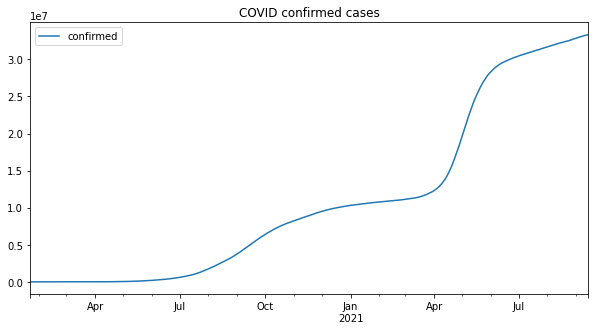

In [40]:
#Total COVID confirmed cases
df_confirmed = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
#df_confirmed.to_csv('time_series_covid19_confirmed_global.csv')
df_confirmed_country = df_confirmed[df_confirmed["Country/Region"] == country]
df_confirmed_country = pd.DataFrame(df_confirmed_country[df_confirmed_country.columns[4:]].sum(),columns=["confirmed"])
df_confirmed_country.index = pd.to_datetime(df_confirmed_country.index,format='%m/%d/%y')

df_confirmed_country.plot(figsize=(10,5),title="COVID confirmed cases")

print(df_confirmed_country.tail(10))

print("Total days in the dataset", len(df_confirmed_country))

In [41]:
#Use data until 14 days before as training
x = len(df_confirmed_country)-14

train=df_confirmed_country.iloc[:x]
test = df_confirmed_country.iloc[x:]

In [42]:
##scale or normalize data as the data is too skewed
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train) 

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [43]:
## Use TimeSeriestrain_generator to generate data in sequences.
#Alternatively we can create our own sequences. 
from keras.preprocessing.sequence import TimeseriesGenerator

In [44]:
#Sequence size has an impact on prediction, especially since COVID is unpredictable!
seq_size = 7  ## number of steps (lookback)
n_features = 1 ## number of features. This dataset is univariate so it is 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(train)) # 271
print("Total number of samples in the generated data = ", len(train_generator)) # 264 with seq_size=7

Total number of samples in the original training data =  588
Total number of samples in the generated data =  581


In [45]:
#Check data shape from generator
#x,y = train_generator[10]  #Check train_generator
#Takes 7 days as x and 8th day as y (for seq_size=7)
#print(x)
#print(y)

In [46]:
#Also generate test data
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test)) # 14 as we're using last 14 days for test
print("Total number of samples in the generated data = ", len(test_generator)) # 7
#Check data shape from generator
x,y = test_generator[0]
print(x)
print(y)

Total number of samples in the original training data =  14
Total number of samples in the generated data =  7
[[[1.00143526]
  [1.00281748]
  [1.00411638]
  [1.00541979]
  [1.00660684]
  [1.00755842]
  [1.00871276]]]
[[1.01003132]]


In [47]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
#Define Model 
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(64))
model.add(Dense(1))

model.summary()
print('Train...')
##########################

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 7, 150)            91200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                55040     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 150,465
Trainable params: 150,465
Non-trainable params: 0
_________________________________________________________________
Train...


In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [35]:
history = model.fit_generator(train_generator, 
                              validation_data=test_generator, 
                              epochs=1000, steps_per_epoch=10, verbose=1)

Epoch 1/1000
10/10 [==============================] - 0s 22ms/step - loss: 4.0121e-05 - val_loss: 7.1169e-07
Epoch 2/1000
10/10 [==============================] - 0s 21ms/step - loss: 5.2711e-05 - val_loss: 7.0844e-05
Epoch 3/1000
10/10 [==============================] - 0s 15ms/step - loss: 7.0554e-05 - val_loss: 5.0739e-05
Epoch 4/1000
10/10 [==============================] - 0s 16ms/step - loss: 3.4994e-05 - val_loss: 4.5386e-04
Epoch 5/1000
10/10 [==============================] - 0s 23ms/step - loss: 3.4749e-05 - val_loss: 8.3227e-04
Epoch 6/1000
10/10 [==============================] - ETA: 0s - loss: 1.2107e-0 - 0s 19ms/step - loss: 1.2107e-05 - val_loss: 0.0011
Epoch 7/1000
10/10 [==============================] - 0s 18ms/step - loss: 1.7395e-04 - val_loss: 4.3330e-04
Epoch 8/1000
10/10 [==============================] - 0s 19ms/step - loss: 1.7981e-04 - val_loss: 4.7159e-05
Epoch 9/1000
10/10 [==============================] - 0s 20ms/step - loss: 5.7897e-05 - val_loss: 2.6016

10/10 [==============================] - 0s 16ms/step - loss: 9.5517e-05 - val_loss: 4.9191e-04
Epoch 76/1000
10/10 [==============================] - 0s 17ms/step - loss: 2.5505e-04 - val_loss: 4.3131e-05
Epoch 77/1000
10/10 [==============================] - 0s 16ms/step - loss: 2.4840e-04 - val_loss: 0.0013
Epoch 78/1000
10/10 [==============================] - 0s 15ms/step - loss: 2.7548e-04 - val_loss: 4.9360e-04
Epoch 79/1000
10/10 [==============================] - 0s 16ms/step - loss: 5.2954e-04 - val_loss: 9.3572e-04
Epoch 80/1000
10/10 [==============================] - 0s 19ms/step - loss: 2.3360e-04 - val_loss: 7.3276e-04
Epoch 81/1000
10/10 [==============================] - 0s 15ms/step - loss: 4.5748e-05 - val_loss: 2.1611e-04
Epoch 82/1000
10/10 [==============================] - 0s 17ms/step - loss: 1.7775e-05 - val_loss: 3.7300e-05
Epoch 83/1000
10/10 [==============================] - 0s 16ms/step - loss: 4.3853e-05 - val_loss: 9.3652e-05
Epoch 84/1000
10/10 [=======

10/10 [==============================] - ETA: 0s - loss: 1.0000e-0 - 0s 17ms/step - loss: 2.0279e-05 - val_loss: 0.0015
Epoch 150/1000
10/10 [==============================] - 0s 19ms/step - loss: 5.5697e-05 - val_loss: 2.7278e-05
Epoch 151/1000
10/10 [==============================] - 0s 16ms/step - loss: 5.3591e-05 - val_loss: 6.3641e-04
Epoch 152/1000
10/10 [==============================] - 0s 16ms/step - loss: 8.4293e-05 - val_loss: 5.9447e-07
Epoch 153/1000
10/10 [==============================] - 0s 14ms/step - loss: 2.0017e-05 - val_loss: 1.4311e-04
Epoch 154/1000
10/10 [==============================] - 0s 15ms/step - loss: 1.0731e-05 - val_loss: 2.6317e-05
Epoch 155/1000
10/10 [==============================] - 0s 16ms/step - loss: 2.3934e-05 - val_loss: 3.5796e-04
Epoch 156/1000
10/10 [==============================] - 0s 14ms/step - loss: 8.0713e-06 - val_loss: 8.6875e-05
Epoch 157/1000
10/10 [==============================] - 0s 14ms/step - loss: 6.2337e-06 - val_loss: 1.2

Epoch 223/1000
10/10 [==============================] - 0s 15ms/step - loss: 9.6315e-06 - val_loss: 2.1130e-04
Epoch 224/1000
10/10 [==============================] - 0s 15ms/step - loss: 6.9125e-06 - val_loss: 1.2650e-04
Epoch 225/1000
10/10 [==============================] - 0s 13ms/step - loss: 1.1524e-05 - val_loss: 5.8661e-05
Epoch 226/1000
10/10 [==============================] - 0s 14ms/step - loss: 6.9780e-06 - val_loss: 5.5193e-05
Epoch 227/1000
10/10 [==============================] - 0s 15ms/step - loss: 6.2515e-06 - val_loss: 3.9246e-04
Epoch 228/1000
10/10 [==============================] - 0s 15ms/step - loss: 4.0410e-06 - val_loss: 6.7836e-05
Epoch 229/1000
10/10 [==============================] - 0s 15ms/step - loss: 1.2781e-05 - val_loss: 6.7168e-05
Epoch 230/1000
10/10 [==============================] - 0s 14ms/step - loss: 9.1685e-06 - val_loss: 4.3493e-04
Epoch 231/1000
10/10 [==============================] - 0s 13ms/step - loss: 2.4267e-05 - val_loss: 9.2131e-05
E

10/10 [==============================] - 0s 16ms/step - loss: 7.2303e-06 - val_loss: 1.0701e-05
Epoch 297/1000
10/10 [==============================] - 0s 21ms/step - loss: 1.5444e-05 - val_loss: 2.6109e-05
Epoch 298/1000
10/10 [==============================] - 0s 22ms/step - loss: 4.4019e-05 - val_loss: 2.9903e-07
Epoch 299/1000
10/10 [==============================] - 0s 15ms/step - loss: 9.4333e-06 - val_loss: 7.1036e-05
Epoch 300/1000
10/10 [==============================] - 0s 14ms/step - loss: 1.5392e-06 - val_loss: 1.2352e-04
Epoch 301/1000
10/10 [==============================] - 0s 14ms/step - loss: 4.5536e-06 - val_loss: 1.7068e-04
Epoch 302/1000
10/10 [==============================] - 0s 13ms/step - loss: 4.7999e-06 - val_loss: 9.1509e-05
Epoch 303/1000
10/10 [==============================] - 0s 13ms/step - loss: 1.9597e-05 - val_loss: 4.4877e-04
Epoch 304/1000
10/10 [==============================] - 0s 14ms/step - loss: 6.7410e-05 - val_loss: 7.8225e-04
Epoch 305/1000
1

10/10 [==============================] - 0s 15ms/step - loss: 3.9911e-05 - val_loss: 5.4906e-07
Epoch 371/1000
10/10 [==============================] - 0s 15ms/step - loss: 3.8420e-05 - val_loss: 2.7326e-04
Epoch 372/1000
10/10 [==============================] - 0s 27ms/step - loss: 1.7525e-05 - val_loss: 2.8282e-05
Epoch 373/1000
10/10 [==============================] - 0s 14ms/step - loss: 3.1875e-05 - val_loss: 3.3574e-05
Epoch 374/1000
10/10 [==============================] - 0s 15ms/step - loss: 1.3208e-05 - val_loss: 1.2357e-04
Epoch 375/1000
10/10 [==============================] - 0s 14ms/step - loss: 9.6149e-06 - val_loss: 1.3984e-04
Epoch 376/1000
10/10 [==============================] - 0s 14ms/step - loss: 1.0762e-05 - val_loss: 1.9567e-05
Epoch 377/1000
10/10 [==============================] - 0s 14ms/step - loss: 1.8134e-06 - val_loss: 1.7286e-04
Epoch 378/1000
10/10 [==============================] - 0s 18ms/step - loss: 1.0543e-05 - val_loss: 3.2354e-06
Epoch 379/1000
1

Epoch 445/1000
10/10 [==============================] - 0s 13ms/step - loss: 8.4756e-06 - val_loss: 9.0431e-05
Epoch 446/1000
10/10 [==============================] - 0s 14ms/step - loss: 6.3332e-06 - val_loss: 5.7592e-06
Epoch 447/1000
10/10 [==============================] - 0s 15ms/step - loss: 5.7843e-06 - val_loss: 1.2056e-05
Epoch 448/1000
10/10 [==============================] - 0s 14ms/step - loss: 6.8586e-06 - val_loss: 2.5058e-05
Epoch 449/1000
10/10 [==============================] - 0s 14ms/step - loss: 1.7711e-05 - val_loss: 7.8266e-05
Epoch 450/1000
10/10 [==============================] - 0s 14ms/step - loss: 5.7609e-06 - val_loss: 1.3439e-08
Epoch 451/1000
10/10 [==============================] - 0s 13ms/step - loss: 1.1789e-05 - val_loss: 2.6286e-05
Epoch 452/1000
10/10 [==============================] - 0s 15ms/step - loss: 7.7493e-06 - val_loss: 1.1836e-04
Epoch 453/1000
10/10 [==============================] - 0s 16ms/step - loss: 5.9159e-06 - val_loss: 1.6458e-06
E

10/10 [==============================] - 0s 38ms/step - loss: 7.3046e-06 - val_loss: 3.6806e-04
Epoch 519/1000
10/10 [==============================] - 0s 20ms/step - loss: 1.0360e-05 - val_loss: 9.1730e-06
Epoch 520/1000
10/10 [==============================] - 0s 13ms/step - loss: 1.7368e-05 - val_loss: 8.2521e-06
Epoch 521/1000
10/10 [==============================] - 0s 12ms/step - loss: 7.4806e-06 - val_loss: 2.1421e-05
Epoch 522/1000
10/10 [==============================] - 0s 12ms/step - loss: 4.4050e-06 - val_loss: 5.9002e-05
Epoch 523/1000
10/10 [==============================] - 0s 11ms/step - loss: 3.2280e-06 - val_loss: 1.6247e-04
Epoch 524/1000
10/10 [==============================] - 0s 14ms/step - loss: 5.5489e-07 - val_loss: 2.1145e-04
Epoch 525/1000
10/10 [==============================] - 0s 12ms/step - loss: 2.2911e-06 - val_loss: 2.5305e-05
Epoch 526/1000
10/10 [==============================] - 0s 11ms/step - loss: 8.8982e-06 - val_loss: 5.5203e-04
Epoch 527/1000
1

10/10 [==============================] - 0s 10ms/step - loss: 1.5695e-05 - val_loss: 1.0059e-04
Epoch 593/1000
10/10 [==============================] - 0s 10ms/step - loss: 1.7193e-05 - val_loss: 8.7959e-06
Epoch 594/1000
10/10 [==============================] - 0s 9ms/step - loss: 2.0870e-05 - val_loss: 1.6313e-05
Epoch 595/1000
10/10 [==============================] - 0s 10ms/step - loss: 6.3242e-06 - val_loss: 3.3086e-04
Epoch 596/1000
10/10 [==============================] - 0s 9ms/step - loss: 1.5104e-04 - val_loss: 3.8293e-04
Epoch 597/1000
10/10 [==============================] - 0s 10ms/step - loss: 2.0831e-05 - val_loss: 1.2033e-04
Epoch 598/1000
10/10 [==============================] - 0s 9ms/step - loss: 1.4309e-05 - val_loss: 2.7135e-04
Epoch 599/1000
10/10 [==============================] - 0s 11ms/step - loss: 2.6582e-05 - val_loss: 1.0708e-04
Epoch 600/1000
10/10 [==============================] - 0s 10ms/step - loss: 6.0762e-06 - val_loss: 9.9069e-05
Epoch 601/1000
10/1

10/10 [==============================] - 0s 12ms/step - loss: 1.1371e-06 - val_loss: 7.4483e-05
Epoch 667/1000
10/10 [==============================] - 0s 11ms/step - loss: 2.1218e-06 - val_loss: 1.5156e-04
Epoch 668/1000
10/10 [==============================] - 0s 13ms/step - loss: 6.5197e-06 - val_loss: 1.0155e-06
Epoch 669/1000
10/10 [==============================] - 0s 11ms/step - loss: 4.0809e-06 - val_loss: 2.1073e-04
Epoch 670/1000
10/10 [==============================] - 0s 13ms/step - loss: 4.2727e-05 - val_loss: 4.4669e-04
Epoch 671/1000
10/10 [==============================] - 0s 11ms/step - loss: 1.5509e-05 - val_loss: 6.9954e-04
Epoch 672/1000
10/10 [==============================] - 0s 11ms/step - loss: 2.3824e-04 - val_loss: 0.0018
Epoch 673/1000
10/10 [==============================] - 0s 10ms/step - loss: 4.3047e-05 - val_loss: 1.9038e-04
Epoch 674/1000
10/10 [==============================] - 0s 10ms/step - loss: 3.9622e-05 - val_loss: 0.0012
Epoch 675/1000
10/10 [==

10/10 [==============================] - 0s 10ms/step - loss: 1.5569e-05 - val_loss: 2.4541e-04
Epoch 741/1000
10/10 [==============================] - 0s 10ms/step - loss: 3.2932e-05 - val_loss: 7.3544e-05
Epoch 742/1000
10/10 [==============================] - 0s 9ms/step - loss: 1.2519e-04 - val_loss: 6.3053e-06
Epoch 743/1000
10/10 [==============================] - 0s 12ms/step - loss: 4.2512e-04 - val_loss: 8.5215e-05
Epoch 744/1000
10/10 [==============================] - 0s 11ms/step - loss: 4.4112e-04 - val_loss: 3.5323e-04
Epoch 745/1000
10/10 [==============================] - 0s 11ms/step - loss: 2.9469e-04 - val_loss: 0.0017
Epoch 746/1000
10/10 [==============================] - 0s 11ms/step - loss: 4.1063e-04 - val_loss: 0.0017
Epoch 747/1000
10/10 [==============================] - 0s 12ms/step - loss: 4.3537e-05 - val_loss: 5.6594e-08
Epoch 748/1000
10/10 [==============================] - 0s 12ms/step - loss: 8.0896e-05 - val_loss: 1.5322e-05
Epoch 749/1000
10/10 [===

10/10 [==============================] - 0s 10ms/step - loss: 1.4911e-05 - val_loss: 2.3312e-04
Epoch 815/1000
10/10 [==============================] - 0s 9ms/step - loss: 3.1141e-05 - val_loss: 1.4729e-05
Epoch 816/1000
10/10 [==============================] - 0s 9ms/step - loss: 1.0208e-05 - val_loss: 1.8123e-04
Epoch 817/1000
10/10 [==============================] - 0s 10ms/step - loss: 8.8322e-06 - val_loss: 1.5764e-04
Epoch 818/1000
10/10 [==============================] - 0s 9ms/step - loss: 8.2936e-06 - val_loss: 1.7327e-04
Epoch 819/1000
10/10 [==============================] - 0s 9ms/step - loss: 6.4008e-06 - val_loss: 1.5467e-06
Epoch 820/1000
10/10 [==============================] - 0s 9ms/step - loss: 7.1175e-06 - val_loss: 7.2594e-05
Epoch 821/1000
10/10 [==============================] - 0s 10ms/step - loss: 6.9589e-06 - val_loss: 4.8927e-05
Epoch 822/1000
10/10 [==============================] - 0s 10ms/step - loss: 8.9737e-06 - val_loss: 1.3433e-04
Epoch 823/1000
10/10 

10/10 [==============================] - 0s 10ms/step - loss: 7.2442e-06 - val_loss: 1.0345e-04
Epoch 889/1000
10/10 [==============================] - 0s 10ms/step - loss: 3.6987e-05 - val_loss: 1.5793e-04
Epoch 890/1000
10/10 [==============================] - 0s 9ms/step - loss: 1.1097e-04 - val_loss: 5.7144e-04
Epoch 891/1000
10/10 [==============================] - 0s 10ms/step - loss: 5.4473e-05 - val_loss: 0.0011
Epoch 892/1000
10/10 [==============================] - 0s 9ms/step - loss: 4.8275e-04 - val_loss: 4.2437e-05
Epoch 893/1000
10/10 [==============================] - 0s 10ms/step - loss: 2.0957e-04 - val_loss: 0.0015
Epoch 894/1000
10/10 [==============================] - 0s 9ms/step - loss: 8.3728e-05 - val_loss: 0.0022
Epoch 895/1000
10/10 [==============================] - ETA: 0s - loss: 4.2036e-0 - 0s 10ms/step - loss: 4.2036e-04 - val_loss: 0.0035
Epoch 896/1000
10/10 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 8.1546e-04
Epoch 897/10

10/10 [==============================] - 0s 10ms/step - loss: 5.3828e-06 - val_loss: 6.0568e-05
Epoch 963/1000
10/10 [==============================] - 0s 8ms/step - loss: 1.7740e-05 - val_loss: 2.2163e-04
Epoch 964/1000
10/10 [==============================] - 0s 9ms/step - loss: 1.6793e-05 - val_loss: 4.7258e-06
Epoch 965/1000
10/10 [==============================] - 0s 9ms/step - loss: 2.7939e-05 - val_loss: 7.0397e-04
Epoch 966/1000
10/10 [==============================] - 0s 9ms/step - loss: 6.0377e-05 - val_loss: 1.3725e-04
Epoch 967/1000
10/10 [==============================] - 0s 9ms/step - loss: 6.0658e-05 - val_loss: 5.9618e-04
Epoch 968/1000
10/10 [==============================] - 0s 10ms/step - loss: 5.0770e-05 - val_loss: 8.5267e-07
Epoch 969/1000
10/10 [==============================] - 0s 10ms/step - loss: 4.0770e-06 - val_loss: 1.7041e-04
Epoch 970/1000
10/10 [==============================] - 0s 11ms/step - loss: 1.1682e-05 - val_loss: 6.2988e-05
Epoch 971/1000
10/10 

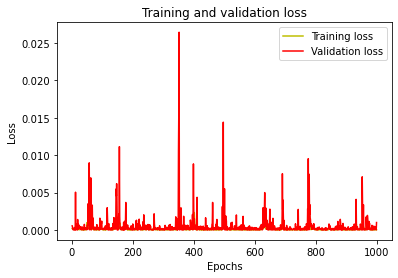

In [28]:
#plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
#forecast
prediction = [] #Empty list to populate later with predictions

current_batch = train_scaled[-seq_size:] #Final data points in train 
current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape

In [30]:
## Predict future, beyond test dates
future = 7 #Days
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [31]:
### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)

time_series_array = test.index  #Get dates for test data
print(test.index)

DatetimeIndex(['2021-09-01', '2021-09-02', '2021-09-03', '2021-09-04',
               '2021-09-05', '2021-09-06', '2021-09-07', '2021-09-08',
               '2021-09-09', '2021-09-10', '2021-09-11', '2021-09-12',
               '2021-09-13', '2021-09-14'],
              dtype='datetime64[ns]', freq=None)


In [32]:
#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))
    
#print(time_series_array)   
#print(pd.DateOffset(1))

In [33]:
#Create a dataframe to capture the forecast data
df_forecast = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)
df_forecast.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast.loc[:,"actual_confirmed"] = test["confirmed"]

<AxesSubplot:title={'center':'Predictions for next 7 days'}>

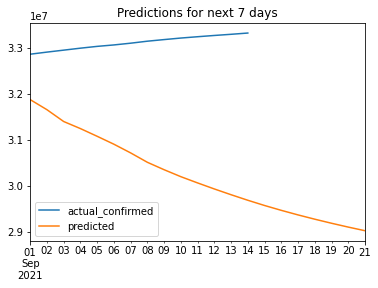

In [34]:
#Plot
df_forecast.plot(title="Predictions for next 7 days")